# Predizione tutte le waves

In [1]:
import pickle as pkl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from aidam.math_utils import moving_function_rev1
#from aidam.aicharts import get_subplot_cells_sequence, confplot_ax,auto_grid_shape
#from aidam.faga.curve_fit import FagaCurveFit
from scipy.optimize import curve_fit
from datetime import datetime, timedelta
from aidam.miscellanea_utils import find_matlabstyle

from covid_lib import read_covid_data, find_day_index

## Lettura dati

In [2]:
trend,regioni,giorni,giorno_settimana,popolazione,day_counter=read_covid_data('stored_data.pkl')

Giorni osservati: 367
Primo giorno: 2020-02-24T18:00:00
Ultimo giorno: 2021-02-24T17:00:00


## Estrapolazione second wave

Inizio nominale second wave: 2020-07-23T17:00:00
Valore nuovi_positivi a inizio second wave: 306.000000


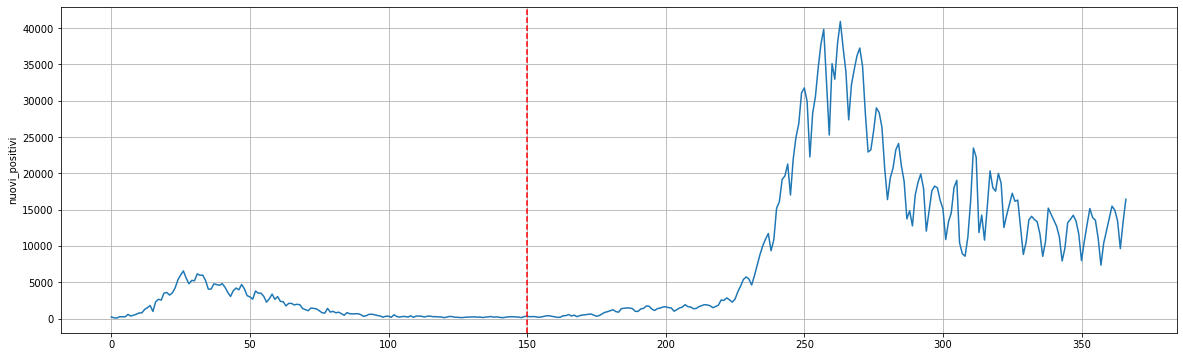

In [3]:
indicatore='nuovi_positivi'
regione='Italia'

# giorno di inizio second wave
if indicatore=='terapia_intensiva':
    sw_start=150
if indicatore=='deceduti_giornalieri':
    sw_start=150
if indicatore=='nuovi_positivi':
    sw_start=150

    
print('Inizio nominale second wave: %s'%giorni[sw_start])



fig,ax=plt.subplots(1,figsize=(20,6))
ax.plot(day_counter,trend[indicatore][regione])
ax.grid()
ax.set_ylabel(indicatore)
ax.axvline(sw_start,c='r',ls='--')


Y=trend[indicatore][regione][sw_start:]


print('Valore %s a inizio second wave: %f'%(indicatore,trend[indicatore][regione][sw_start]))

## Multi-gaussiane

In [4]:
def generic_gaussian(t,a,b,c):
    return a*np.exp(-((t-b)**2)/(2*c**2))

def multi_gaussian_creator(t,num_gaussiane,pars):
    temp=0
    for i in range(num_gaussiane):
        temp+=generic_gaussian(t,*pars[i*3:i*3+3])
    return temp

In [11]:
num_gaussians=3

my_multi_gaussian=lambda t,*pars: multi_gaussian_creator(t,num_gaussians,pars)
#start_point=[1,1,1,1,1,1]

minimi=num_gaussians*[0,0,0]
massimi=num_gaussians*[1.5*np.max(Y),len(Y),len(Y)]
bounds=(minimi,massimi)
start_point=(np.array(bounds[0])+np.array(bounds[1]))/2

#three_gaussians=lambda t,*pars: multi_gaussian(t,3,pars)
#start_point=[1,1,1,1,1,1,1,1,1]

'''
three_gaussians=lambda t,*pars: multi_gaussian(t,3,pars)
# bounds per 3 gaussiane su nuovi positivi
bounds=([1000,10,0,20000,220,0,10000,300,0],[10000,100,100,50000,300,100,50000,500,100])
start_point=(np.array(bounds[0])+np.array(bounds[1]))/2
'''

'\nthree_gaussians=lambda t,*pars: multi_gaussian(t,3,pars)\n# bounds per 3 gaussiane su nuovi positivi\nbounds=([1000,10,0,20000,220,0,10000,300,0],[10000,100,100,50000,300,100,50000,500,100])\nstart_point=(np.array(bounds[0])+np.array(bounds[1]))/2\n'

In [12]:
print(bounds)
print(start_point)

([0, 0, 0, 0, 0, 0, 0, 0, 0], [61353.0, 217, 217, 61353.0, 217, 217, 61353.0, 217, 217])
[30676.5   108.5   108.5 30676.5   108.5   108.5 30676.5   108.5   108.5]


In [13]:
modello_usato=my_multi_gaussian
#solution,pcov=curve_fit(modello_usato,np.arange(len(Y)),Y,p0=start_point)
solution,pcov=curve_fit(modello_usato,np.arange(len(Y)),Y,bounds=bounds,p0=start_point)

solution

array([3.07419993e+04, 1.10805164e+02, 1.49258679e+01, 6.53788259e+03,
       1.56242943e+02, 1.84416136e+01, 1.22158185e+04, 2.17000000e+02,
       7.57529044e+01])

## Simulazione

In [14]:
simulation_days=np.arange(len(Y)+90)
y_pred=np.array(list(map(lambda x:modello_usato(x,*solution),simulation_days)))

Preparazione date

- creo il giorno 0 nel formato *datetime* per poi creare i nuovi plot su questa base
- creo una lista di giorni (in formato di stringhe) partendo dal giorno0

In [15]:
giorno0=datetime.strptime(giorni[sw_start][0:10], "%Y-%m-%d")
str_giorni=[]
for d in range(500):
    str_giorni.append((giorno0+timedelta(d)).strftime("%Y-%m-%d"))
str_giorni=np.array(str_giorni)

oggi=datetime.strftime(datetime.now(), "%Y-%m-%d")
indice_oggi=find_matlabstyle(str_giorni,lambda x:x==oggi)[0]

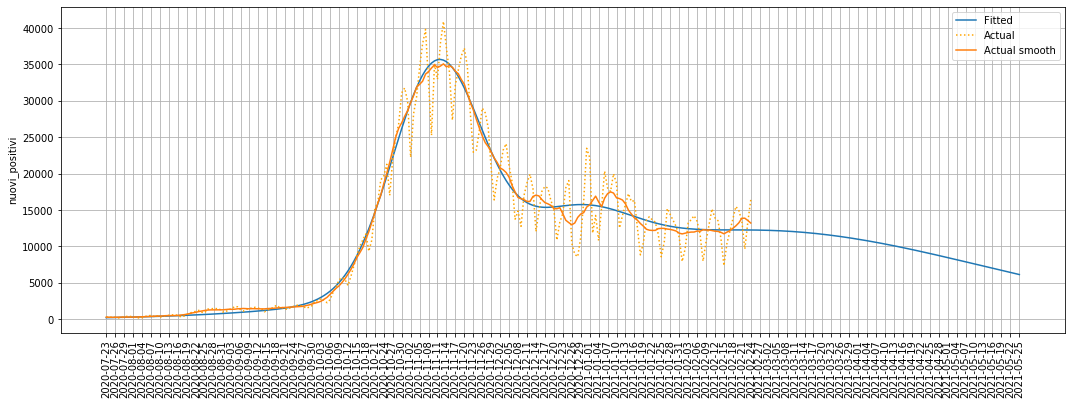

In [16]:
fig,ax=plt.subplots(1,figsize=(18,6))
ax.plot(simulation_days,y_pred,label='Fitted',linestyle='-')
ax.plot(range(len(Y)),Y,label='Actual',linestyle=':',color='orange')
ax.plot(range(len(Y)),moving_function_rev1(Y,np.mean,3,3),label='Actual smooth')
ax.grid()
ax.set_xticks(list(range(0,len(simulation_days),3)))
ax.set_xticklabels(str_giorni[list(range(0,len(simulation_days),3))],rotation=90)

ax.set_ylabel(indicatore)
ax.legend()


In [11]:
for d in simulation_days:
    if d<len(Y):
        print('[%3d]  %s  Act: %6d Pred: %.1f'%(d,str_giorni[d],Y[d],y_pred[d]))
    else:
        print('[%3d]  %s  Act: %6d Pred: %.1f'%(d,str_giorni[d],0,y_pred[d]))   

[  0]  2020-07-23  Act:    306 Pred: 36.2
[  1]  2020-07-24  Act:    252 Pred: 39.0
[  2]  2020-07-25  Act:    275 Pred: 42.0
[  3]  2020-07-26  Act:    255 Pred: 45.2
[  4]  2020-07-27  Act:    170 Pred: 48.6
[  5]  2020-07-28  Act:    212 Pred: 52.3
[  6]  2020-07-29  Act:    289 Pred: 56.2
[  7]  2020-07-30  Act:    386 Pred: 60.4
[  8]  2020-07-31  Act:    379 Pred: 64.8
[  9]  2020-08-01  Act:    295 Pred: 69.6
[ 10]  2020-08-02  Act:    239 Pred: 74.7
[ 11]  2020-08-03  Act:    159 Pred: 80.1
[ 12]  2020-08-04  Act:    190 Pred: 85.8
[ 13]  2020-08-05  Act:    384 Pred: 92.0
[ 14]  2020-08-06  Act:    402 Pred: 98.5
[ 15]  2020-08-07  Act:    552 Pred: 105.4
[ 16]  2020-08-08  Act:    347 Pred: 112.8
[ 17]  2020-08-09  Act:    463 Pred: 120.6
[ 18]  2020-08-10  Act:    259 Pred: 128.9
[ 19]  2020-08-11  Act:    412 Pred: 137.7
[ 20]  2020-08-12  Act:    481 Pred: 147.1
[ 21]  2020-08-13  Act:    523 Pred: 157.0
[ 22]  2020-08-14  Act:    574 Pred: 167.5
[ 23]  2020-08-15  Act:   